# Computational Finance - Assignment 1.1

---
---

This Jupyter notebook contains all the code for the first section of Assignment 1. The content is organized by topic, following the same structure as the accompanying paper.


Run block below for all imports:

In [37]:
# Enable autoreload so that changes in the module are updated immediately
%load_ext autoreload
%autoreload 2

# Import standard libraries
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf
import pandas as pd
from datetime import datetime

# Import functions from the modules
from FinDatSc_Models.spx_vix_regression import *
from FinDatSc_Models.vix_estimator import *
from FinDatSc_Models.volatility_estimators import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
# Volatility and Mean Estimation
---

The following block computes the classical mean, classical volatility, and Parkinson volatility using the functions defined in `volatility_estimators.py`.

In [38]:
# Download data for MSFT
data = download_msft_data(start_date="2010-01-01")
print("Downloaded MSFT data:")
display(data.head())

[*********************100%***********************]  1 of 1 completed

Downloaded MSFT data:


Price,Open,High,Low,Close
Ticker,MSFT,MSFT,MSFT,MSFT
Date,,,,
2010-01-04,30.620001,31.100000,30.590000,30.950001
2010-01-05,30.850000,31.100000,30.639999,30.959999
2010-01-06,30.879999,31.080000,30.520000,30.770000
2010-01-07,30.629999,30.700001,30.190001,30.450001
2010-01-08,30.280001,30.879999,30.240000,30.660000


In [39]:
# Convert to numpy arrays and set dt = 1/252
prices_all = data['Close'].values
highs_all  = data['High'].values
lows_all   = data['Low'].values
dt         = 1.0 / 252.0

# Compute full-sample estimates
mu_full          = classical_mean_equation9(prices_all, dt)
sigma_full       = classical_volatility_equation14(prices_all, mu_full, dt)
park_full_daily  = parkinson_estimator_equation2(highs_all, lows_all)
park_full        = park_full_daily * np.sqrt(252)   # annualize

print("=== FULL-SAMPLE ESTIMATES ===")
print(f"Classical Mean (mu) [Eq. (9)]:      {mu_full:.5f} (annualized)")
print(f"Classical Vol (sigma) [Eq. (14)]:   {sigma_full:.5f} (annualized)")
print(f"Parkinson Vol (sigma) [Eq. (2)]:     {park_full:.5f} (annualized)")

=== FULL-SAMPLE ESTIMATES ===
Classical Mean (mu) [Eq. (9)]:      0.19536 (annualized)
Classical Vol (sigma) [Eq. (14)]:   0.25747 (annualized)
Parkinson Vol (sigma) [Eq. (2)]:     0.20458 (annualized)


Here, we display rolling estimators of the same three functions.

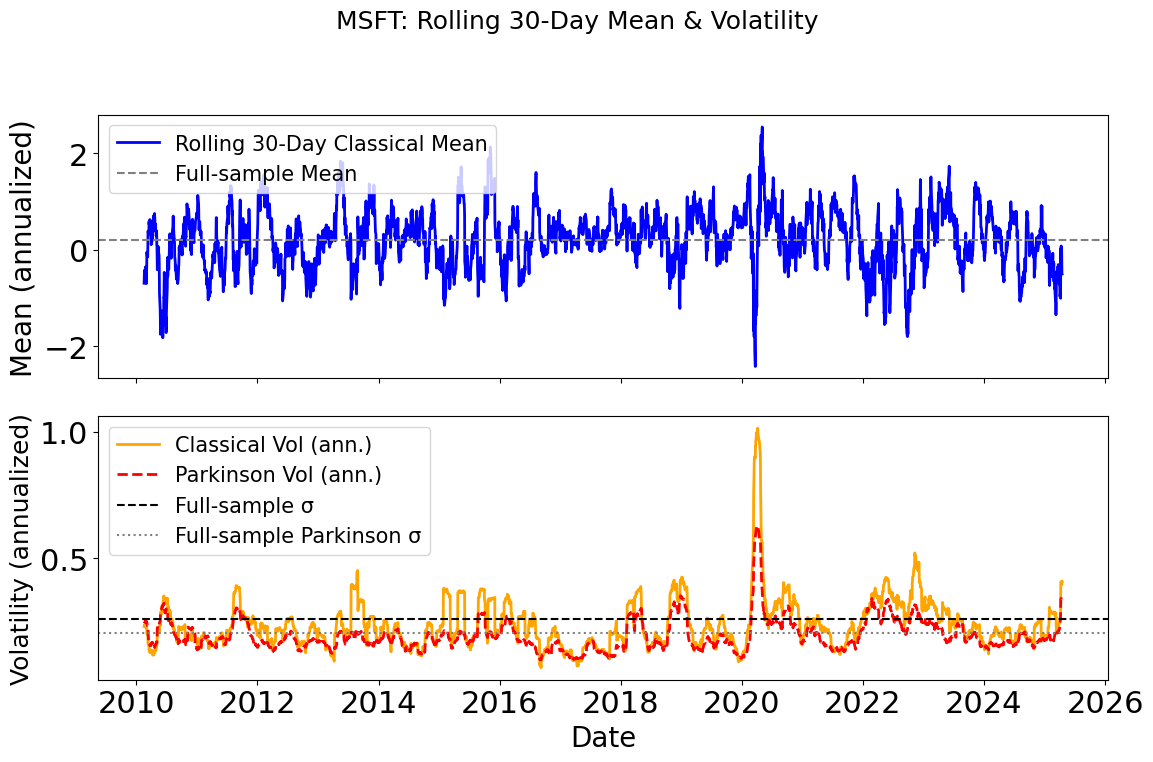

In [40]:
# Annualize Parkinson once up‑front
df_roll['parkinson_ann'] = df_roll['parkinson_rolling'] * np.sqrt(252)

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 1) Top: rolling mean
axes[0].plot(
    df_roll.index, 
    df_roll['mu_rolling'],
    label='Rolling 30‑Day Classical Mean',
    color='blue', 
    linewidth=2
)
# ← ADD full‑sample mean line here:
axes[0].axhline(mu_full, color='gray', linestyle='--', linewidth=1.5, label='Full‑sample Mean')
axes[0].set_ylabel('Mean (annualized)', fontsize=20)
axes[0].legend(loc='upper left', fontsize=15)


# 2) Bottom: both vols
axes[1].plot(
    df_roll.index, 
    df_roll['sigma_rolling'],
    label='Classical Vol (ann.)',
    color='orange', 
    linewidth=2
)
axes[1].plot(
    df_roll.index, 
    df_roll['parkinson_ann'],
    label='Parkinson Vol (ann.)',
    color='red',      
    linewidth=2, 
    linestyle='--'
)
# ← ADD full‑sample volatility lines here:
axes[1].axhline(sigma_full,      color='black', linestyle='--', linewidth=1.5, label='Full‑sample σ')
axes[1].axhline(park_full,       color='gray',  linestyle=':',  linewidth=1.5, label='Full‑sample Parkinson σ')

axes[1].set_ylabel('Volatility (annualized)', fontsize=18)
axes[1].set_xlabel('Date', fontsize=20)
axes[1].legend(loc='upper left', fontsize=15)

# Put the title centered across both subplots
fig.suptitle(
    "MSFT: Rolling 30‑Day Mean & Volatility",
    fontsize=18,
    x=0.5,
    y=0.97 
)

# Make room for the suptitle
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

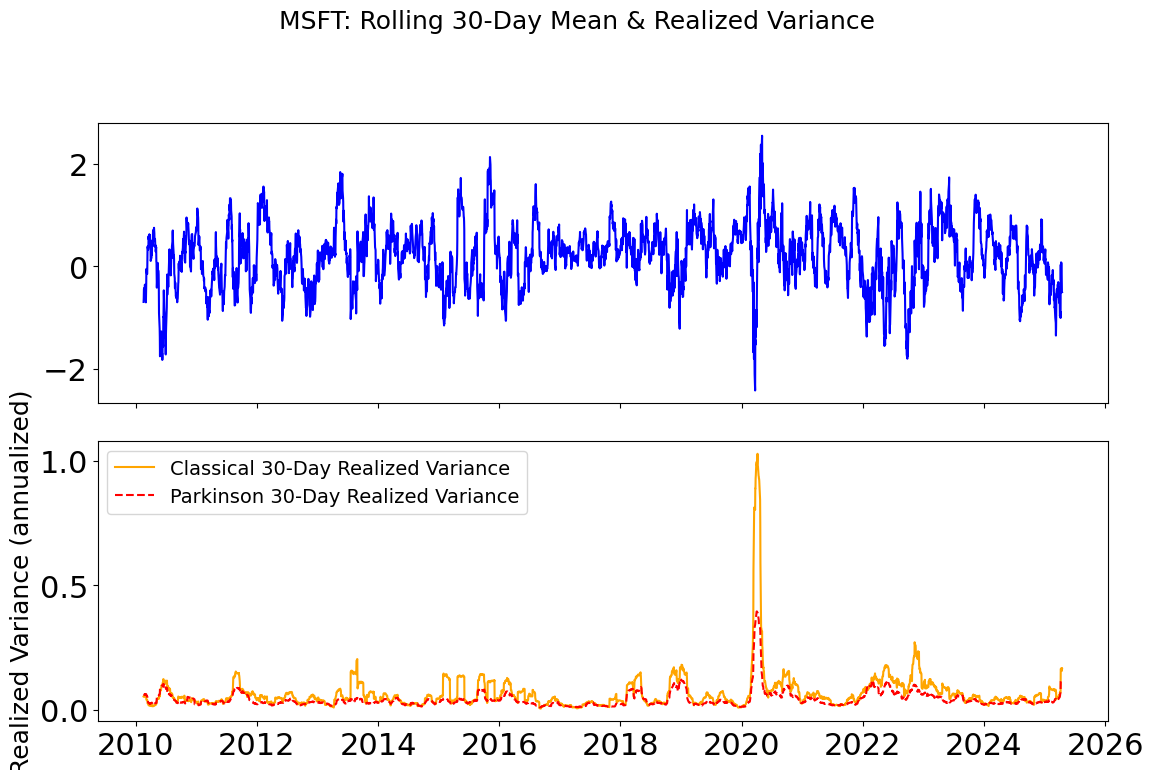

In [41]:
# 1. Compute realized variances (σ²) from the annualized vol series
df_roll['classical_var']   = df_roll['sigma_rolling']**2
df_roll['parkinson_var']   = df_roll['parkinson_ann']  **2

# 2. Plot variance instead of volatility
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# rolling mean stays the same
axes[0].plot(df_roll.index, df_roll['mu_rolling'], label='Rolling 30‑Day Mean', color='blue')

# bottom: realized variances
axes[1].plot(df_roll.index, df_roll['classical_var'], label='Classical 30‑Day Realized Variance', color='orange')
axes[1].plot(df_roll.index, df_roll['parkinson_var'], label='Parkinson 30‑Day Realized Variance', color='red', linestyle='--')
axes[1].set_ylabel('Realized Variance (annualized)', fontsize=18)
axes[1].legend(loc='upper left', fontsize=14)

plt.suptitle("MSFT: Rolling 30‑Day Mean & Realized Variance", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

---
## Comparing Realized Volatility with Implied Volatility
---

[*********************100%***********************]  1 of 1 completed


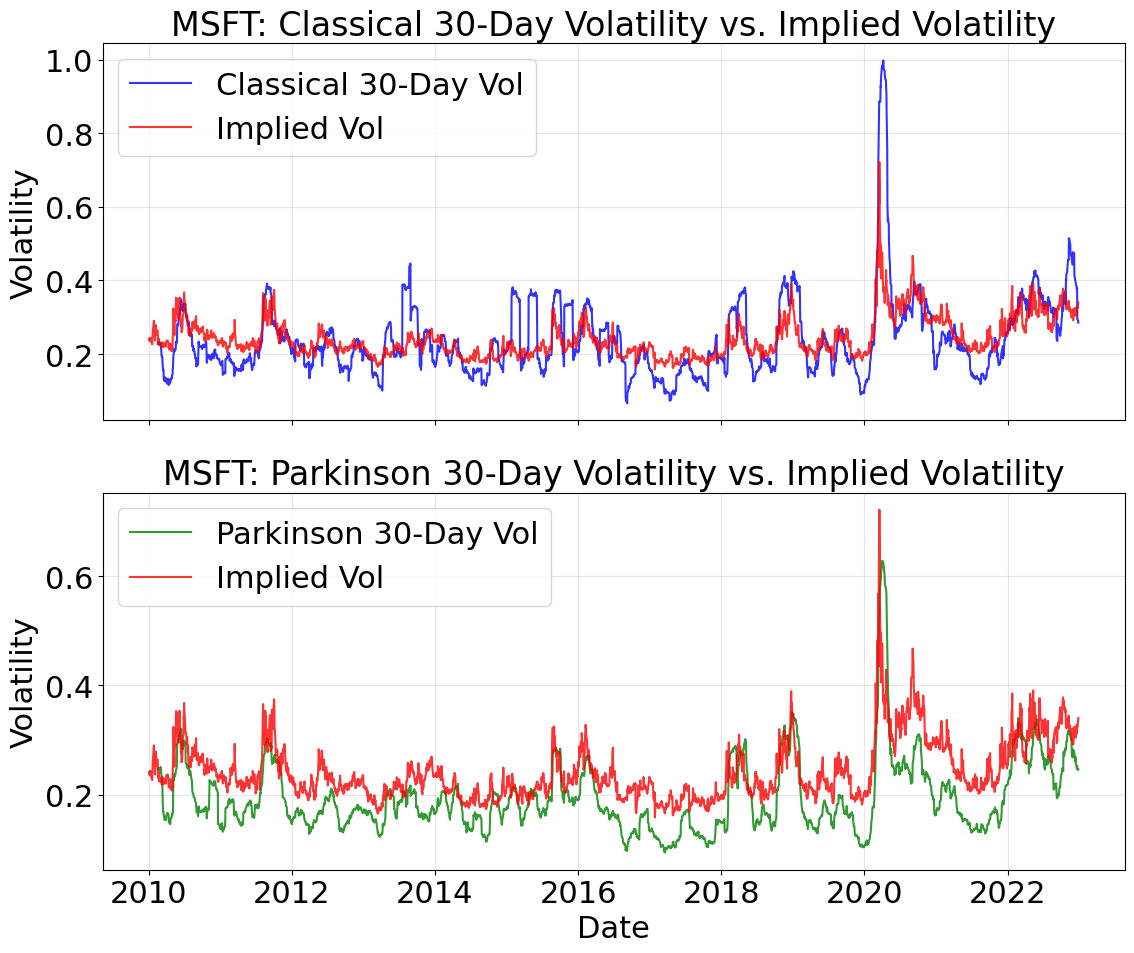

=== Last 5 observations of each series ===
            ClassicalVol  ParkinsonVol  ImpliedVol
2022-12-21      0.376269      0.247448    0.312139
2022-12-22      0.379950      0.252325    0.327944
2022-12-23      0.294942      0.247608    0.323790
2022-12-27      0.290940      0.244892    0.334950
2022-12-28      0.285236      0.245941    0.340077

Pearson correlations:
              ClassicalVol  ParkinsonVol  ImpliedVol
ClassicalVol         1.000         0.746      -0.678
ParkinsonVol         0.746         1.000      -0.299
ImpliedVol          -0.678        -0.299       1.000

=== OLS: Classical Vol ~ Implied Vol ===
                            OLS Regression Results                            
Dep. Variable:                   MSFT   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 18 Apr 2025   Prob (F-statistic)

In [50]:
try:
    from skfolio.datasets import load_sp500_dataset, load_sp500_implied_vol_dataset
    from skfolio.preprocessing import prices_to_returns
    import yfinance as yf
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import statsmodels.api as sm

    # 7.1: Load S&P 500 close‐only prices & implied volatilities
    prices_sp500      = load_sp500_dataset()
    implied_vol_sp500 = load_sp500_implied_vol_dataset()

    # 7.2: Filter to MSFT from 2010 onward
    if "MSFT" not in prices_sp500.columns or "MSFT" not in implied_vol_sp500.columns:
        raise KeyError("MSFT missing from sk‑folio data.")
    msft_close       = prices_sp500["MSFT"].loc["2010":].dropna()
    msft_implied_vol = implied_vol_sp500["MSFT"].loc["2010":].dropna()

    # 7.3: Classical 30‑day realized volatility (annualized)
    msft_close_df     = msft_close.to_frame("MSFT")
    msft_ret          = prices_to_returns(msft_close_df)["MSFT"]
    msft_cl_realized  = msft_ret.rolling(30).std() * np.sqrt(252)

    # 7.3b: Parkinson 30‑day realized volatility (annualized)
    # Pull high/low series from Yahoo to align dates
    yf_data  = yf.download("MSFT", start="2010-01-01", auto_adjust=True)
    msft_hi  = yf_data["High"].loc[msft_cl_realized.index]
    msft_lo  = yf_data["Low"].loc[msft_cl_realized.index]

    park = []
    dates = []
    for i in range(30, len(msft_hi) + 1):
        h_win     = msft_hi.iloc[i-30:i].values
        l_win     = msft_lo.iloc[i-30:i].values
        raw_park  = parkinson_estimator_equation2(h_win, l_win)
        park.append(raw_park * np.sqrt(252))
        dates.append(msft_hi.index[i-1])
    msft_parkinson = pd.Series(park, index=dates)

    # 7.4: Two‐panel plot: Classical vs Implied & Parkinson vs Implied
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # (a) Classical vs Implied
    axes[0].plot(msft_cl_realized, label="Classical 30‑Day Vol", color="blue", linewidth=1.5, alpha=0.8)
    axes[0].plot(msft_implied_vol, label="Implied Vol",      color="red",  linewidth=1.5, alpha=0.8)
    axes[0].set_title("MSFT: Classical 30‑Day Volatility vs. Implied Volatility", fontsize=24)
    axes[0].set_ylabel("Volatility", fontsize=22)
    axes[0].legend(fontsize=22)
    axes[0].grid(alpha=0.3)

    # (b) Parkinson vs Implied
    axes[1].plot(msft_parkinson,    label="Parkinson 30‑Day Vol", color="green", linewidth=1.5, alpha=0.8)
    axes[1].plot(msft_implied_vol,  label="Implied Vol",          color="red",   linewidth=1.5, alpha=0.8)
    axes[1].set_title("MSFT: Parkinson 30‑Day Volatility vs. Implied Volatility", fontsize=24)
    axes[1].set_ylabel("Volatility", fontsize=22)
    axes[1].set_xlabel("Date", fontsize=22)
    axes[1].legend(fontsize=22)
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 7.5: Last‐5 observations comparison
    comparison = pd.concat([
        msft_cl_realized.tail(5).rename("ClassicalVol"),
        msft_parkinson.tail(5).rename("ParkinsonVol"),
        msft_implied_vol.tail(5).rename("ImpliedVol")
    ], axis=1)
    print("=== Last 5 observations of each series ===")
    print(comparison)

    # 7.6: Pearson correlations among the three series
    df_vol = comparison.dropna()
    print("\nPearson correlations:")
    print(df_vol.corr().round(3))

    # 7.7: (Optional) regress each realized vol on implied vol
    for name, series in [("Classical", msft_cl_realized),
                         ("Parkinson", msft_parkinson)]:
        common = series.index.intersection(msft_implied_vol.index)
        Y = series.loc[common]
        X = sm.add_constant(msft_implied_vol.loc[common])
        model = sm.OLS(Y, X).fit()
        print(f"\n=== OLS: {name} Vol ~ Implied Vol ===")
        print(model.summary())

except ImportError:
    print("skfolio not installed. Run `pip install skfolio`.")

Classical vs Implied Vol:   Pearson r = 0.706,  p = 0


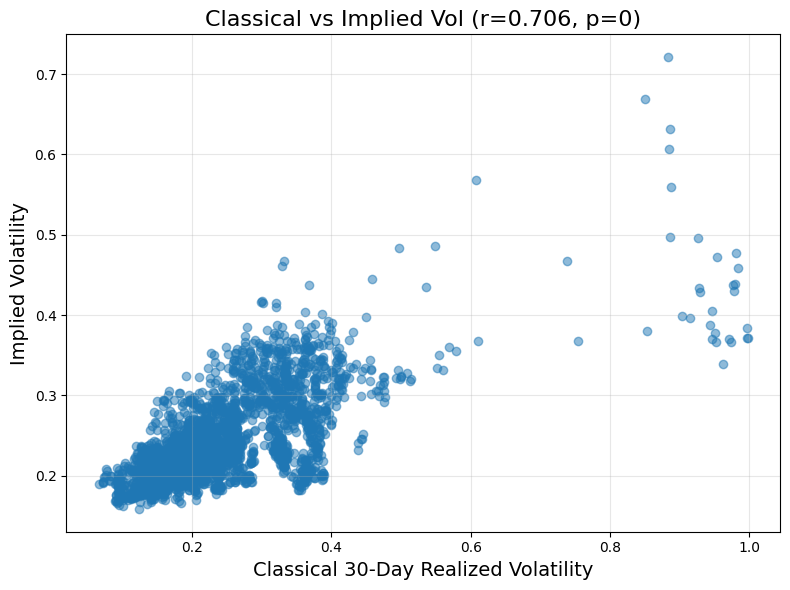

NameError: name 'msft_parkinson' is not defined

In [ ]:
# Classical 30‑Day Realized Volatility vs Implied Volatility
df1 = pd.concat([
    msft_cl_realized.rename("ClassicalVol"),
    msft_implied_vol.rename("ImpliedVol")
], axis=1).dropna()

r1, p1 = pearsonr(df1["ClassicalVol"], df1["ImpliedVol"])
print(f"Classical vs Implied Vol:   Pearson r = {r1:.3f},  p = {p1:.3g}")

plt.figure(figsize=(8,6))
plt.scatter(df1["ClassicalVol"], df1["ImpliedVol"], alpha=0.5)
plt.xlabel("Classical 30‑Day Realized Volatility", fontsize=14)
plt.ylabel("Implied Volatility", fontsize=14)
plt.title(f"Classical vs Implied Vol (r={r1:.3f}, p={p1:.3g})", fontsize=16)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Parkinson 30‑Day Realized Volatility vs Implied Volatility
df2 = pd.concat([
    msft_parkinson.rename("ParkinsonVol"),
    msft_implied_vol.rename("ImpliedVol")
], axis=1).dropna()

r2, p2 = pearsonr(df2["ParkinsonVol"], df2["ImpliedVol"])
print(f"Parkinson vs Implied Vol:   Pearson r = {r2:.3f},  p = {p2:.3g}")

plt.figure(figsize=(8,6))
plt.scatter(df2["ParkinsonVol"], df2["ImpliedVol"], alpha=0.5, color="green")
plt.xlabel("Parkinson 30‑Day Realized Volatility", fontsize=14)
plt.ylabel("Implied Volatility", fontsize=14)
plt.title(f"Parkinson vs Implied Vol (r={r2:.3f}, p={p2:.3g})", fontsize=16)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

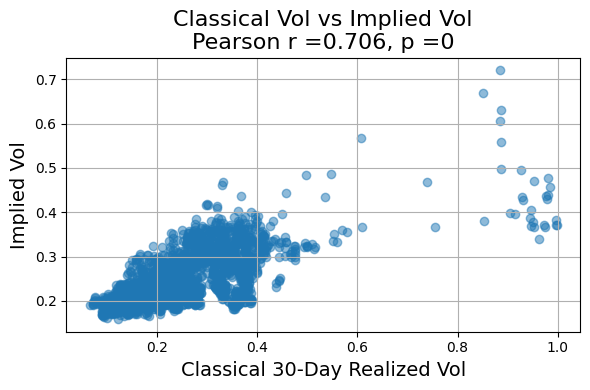

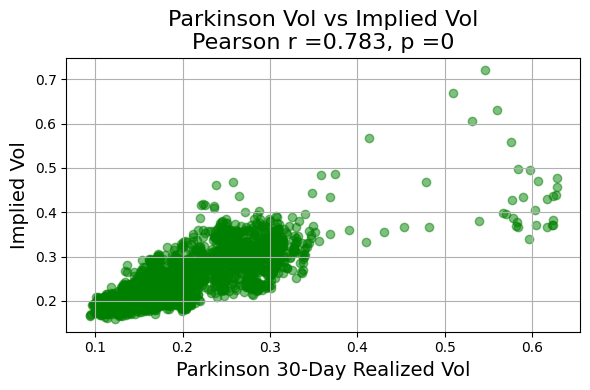

In [19]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# prepare & clean Classical vs Implied
df_cl = pd.concat([
    msft_cl_realized.rename("ClVol"),
    msft_implied_vol.rename("ImpVol")
], axis=1).dropna()
x_cl, y_cl = df_cl["ClVol"], df_cl["ImpVol"]
r_cl, p_cl = pearsonr(x_cl, y_cl)

# — Figure 1: Classical vs Implied —
plt.figure(figsize=(6,4))
plt.scatter(x_cl, y_cl, alpha=0.5)
plt.title(f"Classical Vol vs Implied Vol\nPearson r ={r_cl:.3f}, p ={p_cl:.2g}", fontsize=16)
plt.xlabel("Classical 30‑Day Realized Vol", fontsize=14)
plt.ylabel("Implied Vol", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


# prepare & clean Parkinson vs Implied
df_pk = pd.concat([
    msft_parkinson.rename("PkVol"),
    msft_implied_vol.rename("ImpVol")
], axis=1).dropna()
x_pk, y_pk = df_pk["PkVol"], df_pk["ImpVol"]
r_pk, p_pk = pearsonr(x_pk, y_pk)

# — Figure 2: Parkinson vs Implied —
plt.figure(figsize=(6,4))
plt.scatter(x_pk, y_pk, alpha=0.5, color="green")
plt.title(f"Parkinson Vol vs Implied Vol\nPearson r ={r_pk:.3f}, p ={p_pk:.2g}", fontsize=16)
plt.xlabel("Parkinson 30‑Day Realized Vol", fontsize=14)
plt.ylabel("Implied Vol", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

---
# VIX Estimators
---

We fetch SPX price history and corresponding VIX value for the most recent business day.

In [7]:
spx_data, vix_data, last_bus_day = download_spx_and_vix("2025-03-05")

S0 = spx_data["Close"].iloc[-1].item()
r = 0.02  # Risk-free rate
T = 1.0   # Time to maturity (1 year)

F0 = compute_forward_price(S0, r, T)

print("Spot Price (S0):", round(S0, 2))
print("Forward Price (F0):", round(F0, 2))
print("Last SPX Business Day:", last_bus_day.date())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Spot Price (S0): 5778.15
Forward Price (F0): 5894.88
Last SPX Business Day: 2025-03-04


We select the nearest available expiry (`2025-04-15`) for VIX estimation.

In [8]:
spx_ticker = yf.Ticker("^SPX")
print("Available Expiry Dates:", spx_ticker.options)

expiry_date = "2025-04-15"  # Updated to valid expiry
calls_df, puts_df = get_option_chain(spx_ticker, expiry_date)

print("Calls Head:\n", calls_df.head())
print("Puts Head:\n", puts_df.head())

Available Expiry Dates: ('2025-04-15', '2025-04-16', '2025-04-17', '2025-04-21', '2025-04-22', '2025-04-23', '2025-04-24', '2025-04-25', '2025-04-28', '2025-04-29', '2025-04-30', '2025-05-01', '2025-05-02', '2025-05-05', '2025-05-06', '2025-05-07', '2025-05-08', '2025-05-09', '2025-05-12', '2025-05-13', '2025-05-14', '2025-05-15', '2025-05-16', '2025-05-19', '2025-05-20', '2025-05-22', '2025-05-23', '2025-05-30', '2025-06-06', '2025-06-20', '2025-06-30', '2025-07-18', '2025-07-31', '2025-08-15', '2025-08-29', '2025-09-19', '2025-09-30', '2025-10-17', '2025-11-21', '2025-12-19', '2025-12-31', '2026-01-16', '2026-02-20', '2026-03-20', '2026-03-31', '2026-04-17', '2026-06-18', '2026-12-18', '2027-12-17', '2028-12-15', '2029-12-21', '2030-12-20')
Calls Head:
         contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0  SPXW250415C02200000 2025-04-07 14:25:40+00:00  2200.0    2844.30  3182.0   
1  SPXW250415C03000000 2025-04-07 15:04:45+00:00  3000.0    2099.20  2382.2 

Using last traded prices, we estimate VIX following the official approximation.

In [9]:
tau = 30 / 365  # 30-day maturity
vix_est = estimate_vix_equation19(calls_df, puts_df, F0, r, tau)

vix_market = vix_data["Close"].iloc[0].item()

print(f"Estimated VIX (from options): {vix_est:.2f}")
print(f"CBOE VIX (Yahoo Finance):     {vix_market:.2f}")

Estimated VIX (from options): 56.08
CBOE VIX (Yahoo Finance):     23.51


We now use mid-prices, filter invalid values, and restrict strikes to ±20% around F0.

In [10]:
vix_est_improved = estimate_vix_improved(calls_df, puts_df, F0, r, tau)

print(f"Improved Estimated VIX:       {vix_est_improved:.2f}")
print(f"Official VIX (CBOE):          {vix_market:.2f}")

Improved Estimated VIX:       38.58
Official VIX (CBOE):          23.51


---
# Comparison of MSFT 30-Day Realized Volatility and the CBOE VIX 
---

In [ ]:
# Set the date range
end_date = datetime.datetime.now().strftime("%Y-%m-%d")

# Download historical VIX data
vix_hist = yf.download("^VIX", start="2010-01-01", end=end_date, auto_adjust=True)["Close"]

# Create a DataFrame and rename the column to "VIX"
df_vix = pd.DataFrame(vix_hist)
df_vix.rename(columns={"Close": "VIX"}, inplace=True)

# Inspect the first few rows of the VIX data
print("VIX Data:")
print(df_vix.head())

[*********************100%***********************]  1 of 1 completed

VIX Data:
Ticker           ^VIX
Date                 
2010-01-04  20.040001
2010-01-05  19.350000
2010-01-06  19.160000
2010-01-07  19.059999
2010-01-08  18.129999


In [24]:
# If msft_realized_vol_30 is a Series, convert it to a DataFrame for consistency:
if isinstance(msft_realized_vol_30, pd.Series):
    msft_realized_vol_30 = msft_realized_vol_30.to_frame(name="RealizedVol_MSFT")

# Align the two series on common dates
common_dates = df_vix.index.intersection(msft_realized_vol_30.index)
df_compare = pd.concat([msft_realized_vol_30.loc[common_dates], df_vix.loc[common_dates]], axis=1)

# Rename columns to ensure clarity
df_compare.columns = ["RealizedVol_MSFT", "VIX"]

# Display the first few rows to check the merged data
print("Aligned Data:")
print(df_compare.head())

Aligned Data:
            RealizedVol_MSFT        VIX
Date                                   
2010-01-05               NaN  19.350000
2010-01-06               NaN  19.160000
2010-01-07               NaN  19.059999
2010-01-08               NaN  18.129999
2010-01-11               NaN  17.549999


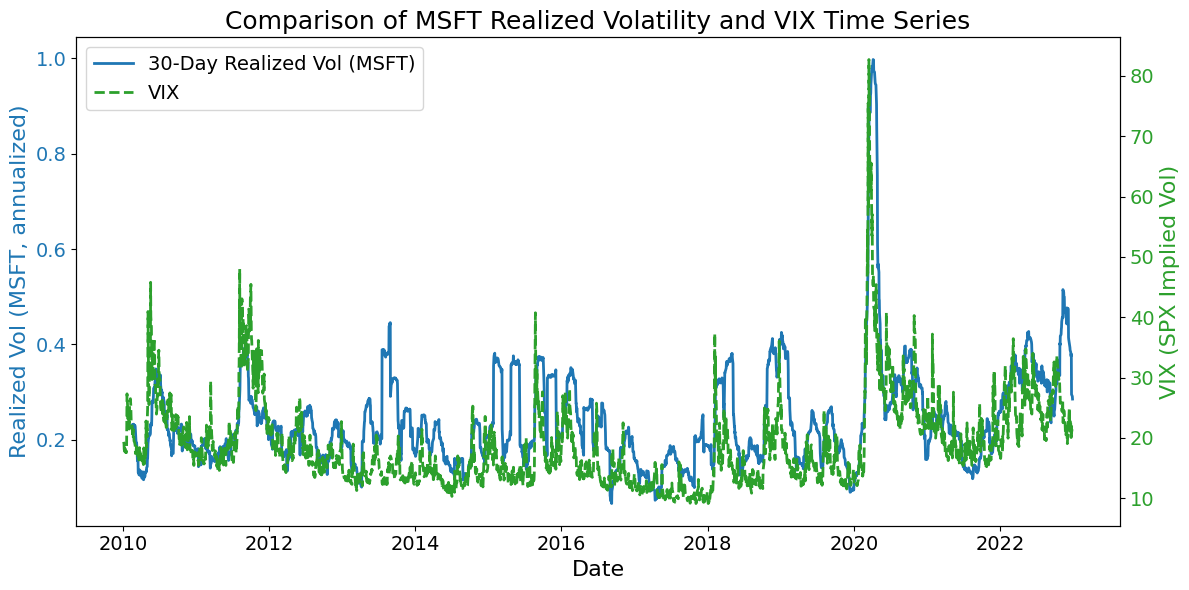

In [25]:
# Create the plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot MSFT realized volatility on the left y-axis
color1 = 'tab:blue'
ax1.set_xlabel("Date", fontsize=16)
ax1.set_ylabel("Realized Vol (MSFT, annualized)", color=color1, fontsize=16)
line1, = ax1.plot(df_compare.index, df_compare["RealizedVol_MSFT"],
                  label="30-Day Realized Vol (MSFT)", color=color1, linewidth=2)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.tick_params(axis='both', labelsize=14)

# Create a second y-axis for VIX data
ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.set_ylabel("VIX (SPX Implied Vol)", color=color2, fontsize=16)
line2, = ax2.plot(df_compare.index, df_compare["VIX"],
                  label="VIX", color=color2, linewidth=2, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.tick_params(axis='both', labelsize=14)

# Combine legends from both y-axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=14)

plt.title("Comparison of MSFT Realized Volatility and VIX Time Series", fontsize=18)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


ClassicalVol (annualized) vs VIX → corr = 0.647, coint p‑value = 0.000
ParkinsonVol (annualized) vs VIX → corr = 0.739, coint p‑value = 0.000


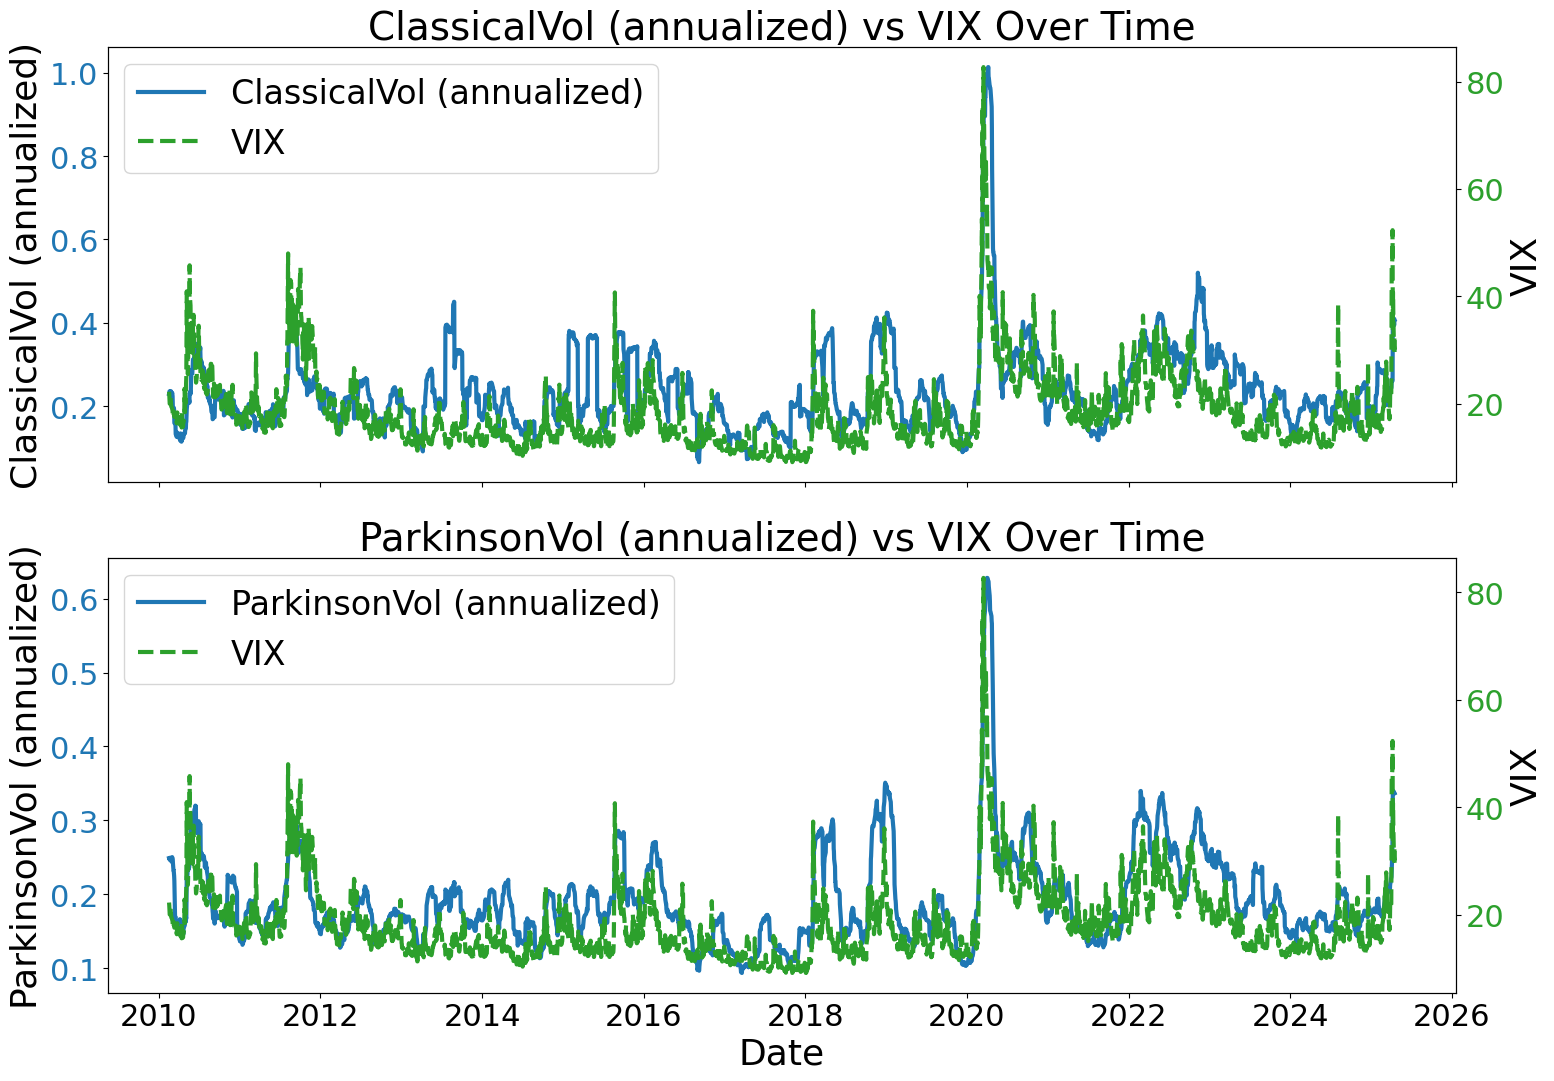

In [52]:
import datetime
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

# your rolling‐window function
from FinDatSc_Models.volatility_estimators import compute_rolling_estimators


msft = yf.download(
    "MSFT",
    start="2010-01-01",
    end=datetime.datetime.now().strftime("%Y-%m-%d")
)
df_roll = compute_rolling_estimators(msft, window_size=30, dt=1/252)
annual_factor = np.sqrt(252)
df_roll["parkinson_ann"] = df_roll["parkinson_rolling"] * annual_factor
vix_raw = yf.download(
    "^VIX",
    start="2010-01-01",
    end=datetime.datetime.now().strftime("%Y-%m-%d")
)
df_vix = (
    vix_raw[["Close"]]
    .rename(columns={"Close": "VIX"})
    if isinstance(vix_raw, pd.DataFrame)
    else vix_raw.to_frame("VIX")
)

plt.rcParams.update({
    "font.size":          22,   # base font size
    "axes.titlesize":     28,   # subplot titles
    "axes.labelsize":     20,   # x/y labels
    "xtick.labelsize":    22,   # x‐tick labels
    "ytick.labelsize":    22,   # y‐tick labels
    "legend.fontsize":    24,   # legend text
    "figure.titlesize":   32,   # suptitle
})

fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

for ax, est_col, name in zip(
    axes,
    ["sigma_rolling", "parkinson_ann"],
    ["ClassicalVol (annualized)", "ParkinsonVol (annualized)"]
):
    # align dates
    common = df_roll.index.intersection(df_vix.index)
    series = df_roll.loc[common, est_col]
    vix    = df_vix.loc[common, "VIX"]
    df_cmp = pd.concat([series, vix], axis=1).dropna()
    df_cmp.columns = [name, "VIX"]

    # stats
    corr = df_cmp[name].corr(df_cmp["VIX"])
    _, pval, _ = coint(df_cmp[name], df_cmp["VIX"])
    print(f"{name} vs VIX → corr = {corr:.3f}, coint p‑value = {pval:.3f}")

    # plot realized vol
    ln1 = ax.plot(
        df_cmp.index, df_cmp[name],
        color="tab:blue", label=name, linewidth=3
    )
    ax.set_ylabel(f"{name}", fontsize=26)
    ax.tick_params(axis="y", labelcolor="tab:blue")

    # twin axis for VIX
    ax2 = ax.twinx()
    ln2 = ax2.plot(
        df_cmp.index, df_cmp["VIX"],
        color="tab:green", linestyle="--", label="VIX", linewidth=3
    )
    ax2.set_ylabel("VIX", fontsize=26)
    ax2.tick_params(axis="y", labelcolor="tab:green")

    # combined legend
    lines  = ln1 + ln2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc="upper left", fontsize=24)
    ax.set_title(f"{name} vs VIX Over Time", fontsize=28)

# final formatting
axes[-1].set_xlabel("Date", fontsize=26)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

---
# Regression Analysis
---

In [29]:
start_date = "2010-01-01"
end_date = "2025-03-05"

spx_data, vix_data = download_spx_vix_data(start_date, end_date)
print("SPX Data:")
print(spx_data.head())
print("\nVIX Data:")
print(vix_data.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

SPX Data:
Price             Close         High          Low         Open      Volume
Ticker             ^SPX         ^SPX         ^SPX         ^SPX        ^SPX
Date                                                                      
2010-01-04  1132.989990  1133.869995  1116.560059  1116.560059  3991400000
2010-01-05  1136.520020  1136.630005  1129.660034  1132.660034  2491020000
2010-01-06  1137.140015  1139.189941  1133.949951  1135.709961  4972660000
2010-01-07  1141.689941  1142.459961  1131.319946  1136.270020  5270680000
2010-01-08  1144.979980  1145.390015  1136.219971  1140.520020  4389590000

VIX Data:
Price           Close       High        Low       Open Volume
Ticker           ^VIX       ^VIX       ^VIX       ^VIX   ^VIX
Date                                                         
2010-01-04  20.040001  21.680000  20.030001  21.680000      0
2010-01-05  19.350000  20.129999  19.340000  20.049999      0
2010-01-06  19.160000  19.680000  18.770000  19.590000      0
2010-01

In [30]:
def download_spx_vix_data(start_date="2010-01-01", end_date="2025-03-05"):
    spx = yf.download("^SPX", start=start_date, end=end_date, auto_adjust=True)
    vix = yf.download("^VIX", start=start_date, end=end_date, auto_adjust=True)
    spx.dropna(inplace=True)
    vix.dropna(inplace=True)
    return spx, vix

def compute_returns_and_realized_variance(spx_data, window=30):
    spx = spx_data.copy()
    spx['Return'] = spx['Close'].pct_change()
    spx_returns = spx['Return'].dropna()
    realized_var = spx_returns.rolling(window).var() * 252
    return spx_returns, realized_var.dropna()

def regression_spx_returns_vs_vix(spx_returns, vix_data):
    dates = spx_returns.index.intersection(vix_data.index)
    y = spx_returns.loc[dates]
    x = vix_data['Close'].loc[dates]
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    return model, y, x

def regression_spx_returns_vs_realized_variance(spx_returns, realized_variance):
    dates = spx_returns.index.intersection(realized_variance.index)
    y = spx_returns.loc[dates]
    x = realized_variance.loc[dates]
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    return model, y, x

def regression_spx_returns_vs_delta_vix(spx_returns, vix_data):
    # Align SPX returns and VIX close, then diff VIX
    common = spx_returns.index.intersection(vix_data.index)
    y = spx_returns.loc[common]
    v = vix_data['Close'].loc[common]
    dv = v.diff().dropna()
    y2 = y.loc[dv.index]   # drop first date
    X = sm.add_constant(dv)
    model = sm.OLS(y2, X).fit()
    return model, y2, dv

def plot_regression(x, y, model, xlabel, title, color='blue', line_color='red'):
    plt.figure(figsize=(10,6))
    plt.scatter(x, y, alpha=0.5, color=color, label='Data')
    xr = np.linspace(x.min(), x.max(), 100)
    Xr = sm.add_constant(xr)
    plt.plot(xr, model.predict(Xr), color=line_color, label='Fitted Line')
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel("SPX Daily Return", fontsize=16)
    plt.title(title, fontsize=18)
    plt.legend()
    plt.tight_layout()
    plt.show()

def regression_diagnostics(model, X):
    resid = model.resid
    lm_stat, lm_p, f_stat, f_p = het_breuschpagan(resid, X)
    adf_stat, adf_p, *_ = adfuller(resid)
    return {
        'BP LM stat': lm_stat,
        'BP LM p-val': lm_p,
        'BP F stat': f_stat,
        'BP F p-val': f_p,
        'ADF stat': adf_stat,
        'ADF p-val': adf_p
    }

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

=== SPX Returns vs. VIX Level ===
                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     100.6
Date:                Fri, 18 Apr 2025   Prob (F-statistic):           2.18e-23
Time:                        19:57:39   Log-Likelihood:                 11896.
No. Observations:                3814   AIC:                        -2.379e+04
Df Residuals:                    3812   BIC:                        -2.378e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0

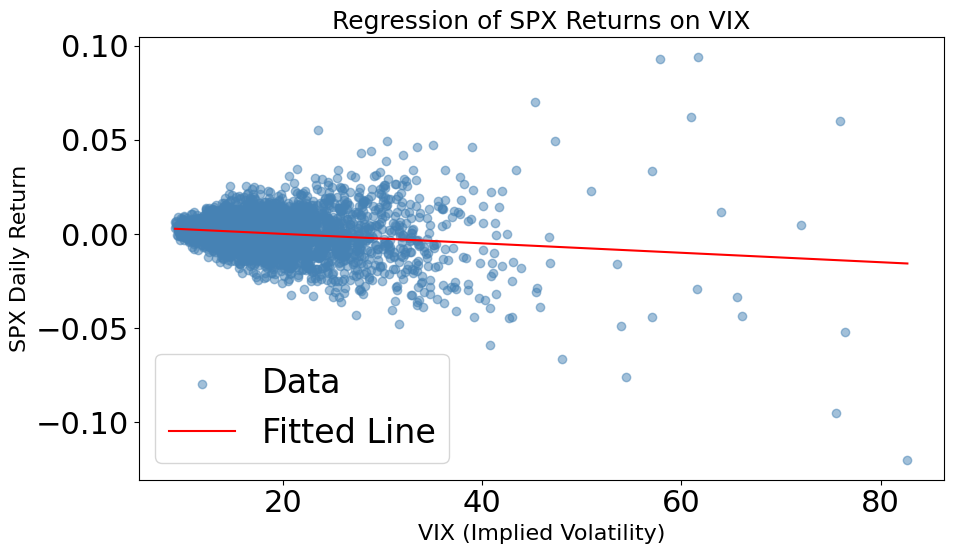


=== SPX Returns vs. Realized Variance ===
                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.243
Date:                Fri, 18 Apr 2025   Prob (F-statistic):             0.0395
Time:                        19:57:39   Log-Likelihood:                 11760.
No. Observations:                3785   AIC:                        -2.352e+04
Df Residuals:                    3783   BIC:                        -2.350e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

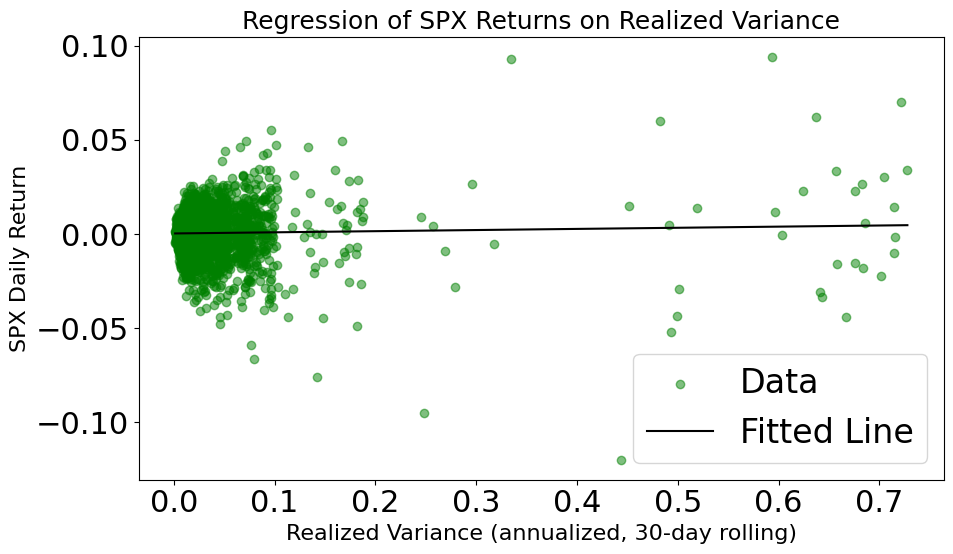


=== SPX Returns vs. ΔVIX ===
                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     6725.
Date:                Fri, 18 Apr 2025   Prob (F-statistic):               0.00
Time:                        19:57:39   Log-Likelihood:                 13785.
No. Observations:                3814   AIC:                        -2.757e+04
Df Residuals:                    3812   BIC:                        -2.755e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005 

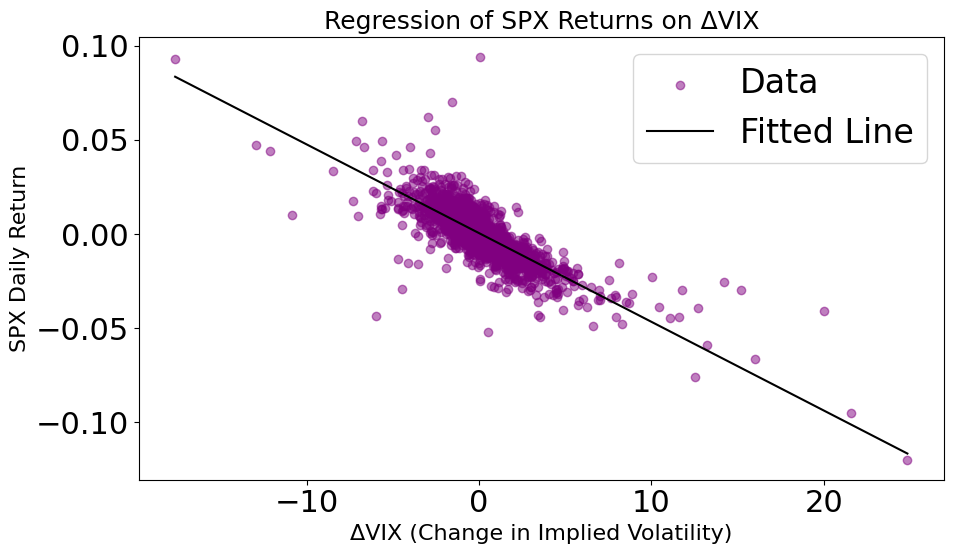


--- Diagnostics: SPX vs VIX Level ---
LM Statistic: 959.0973
LM p-value: 0.0000
F-Statistic: 1280.6318
F p-value: 0.0000
ADF Statistic: -10.7227
ADF p-value: 0.0000

--- Diagnostics: SPX vs Realized Variance ---
LM Statistic: 578.5630
LM p-value: 0.0000
F-Statistic: 682.5969
F p-value: 0.0000
ADF Statistic: -12.9611
ADF p-value: 0.0000

--- Diagnostics: SPX vs ΔVIX ---
LM Statistic: 0.0264
LM p-value: 0.8708
F-Statistic: 0.0264
F p-value: 0.8709
ADF Statistic: -13.4610
ADF p-value: 0.0000


In [48]:
# Parameters
start_date = "2010-01-01"
end_date   = "2025-03-05"
window     = 30

# 1) Download data
spx_data, vix_data = download_spx_vix_data(start_date, end_date)

# 2) Compute returns & realized variance
spx_returns, realized_variance = compute_returns_and_realized_variance(spx_data, window)

# 3) Regression: SPX returns vs VIX level
model_vix, y_vix, x_vix = regression_spx_returns_vs_vix(spx_returns, vix_data)
print("=== SPX Returns vs. VIX Level ===")
print(model_vix.summary())
plot_regression(
    x_vix, y_vix, model_vix,
    xlabel="VIX (Implied Volatility)",
    title="Regression of SPX Returns on VIX",
    color='steelblue',
    line_color='red'
)

# 4) Regression: SPX returns vs Realized Variance
model_rv, y_rv, x_rv = regression_spx_returns_vs_realized_variance(spx_returns, realized_variance)
print("\n=== SPX Returns vs. Realized Variance ===")
print(model_rv.summary())
plot_regression(
    x_rv, y_rv, model_rv,
    xlabel="Realized Variance (annualized, 30-day rolling)",
    title="Regression of SPX Returns on Realized Variance",
    color='green',
    line_color='black'
)

# 5) Regression: SPX returns vs ΔVIX
model_dv, y_dv, x_dv = regression_spx_returns_vs_delta_vix(spx_returns, vix_data)
print("\n=== SPX Returns vs. ΔVIX ===")
print(model_dv.summary())
plot_regression(
    x_dv, y_dv, model_dv,
    xlabel="ΔVIX (Change in Implied Volatility)",
    title="Regression of SPX Returns on ΔVIX",
    color='purple',
    line_color='black'
)

# 6) Diagnostics
print("\n--- Diagnostics: SPX vs VIX Level ---")
X_vix = sm.add_constant(x_vix)
for k,v in regression_diagnostics(model_vix, X_vix).items():
    print(f"{k}: {v:.4f}")

print("\n--- Diagnostics: SPX vs Realized Variance ---")
X_rv = sm.add_constant(x_rv)
for k,v in regression_diagnostics(model_rv, X_rv).items():
    print(f"{k}: {v:.4f}")

print("\n--- Diagnostics: SPX vs ΔVIX ---")
X_dv = sm.add_constant(x_dv)
for k,v in regression_diagnostics(model_dv, X_dv).items():
    print(f"{k}: {v:.4f}")